Image file path: C:\Users\dovsa\OneDrive\Desktop\Fertility Project\Dov's Data\Sample 1 Capacitated with P4\GFP5.jpg


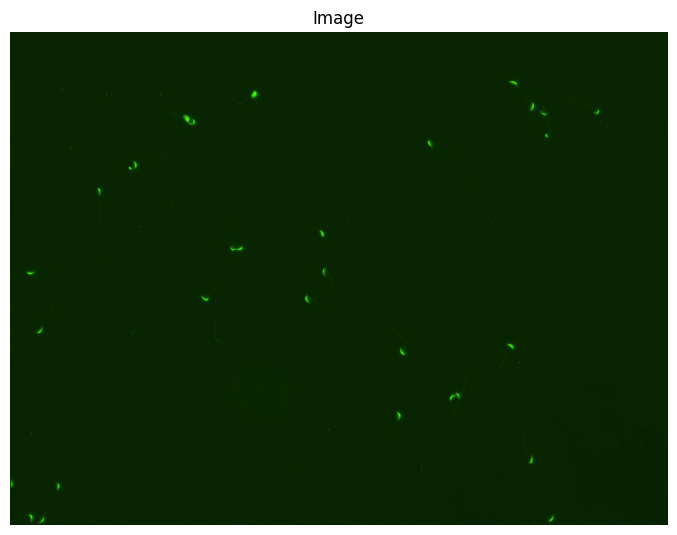

In [1]:
# Acrosome Detection using OpenCV
# This script finds regions of interest (ROIs) in an image based on pixel intensity and size.
# High-pass filtering is used to ignore low-frequency features such as bubbles and dirt. 
# The final ROIs are displayed on the original image.

# This script was used to detect acrosomes (labeled with GFP) in sperm cells, which are critical for the fertilization process.

# Specify the path to the image file
img_file_path = r"C:\Users\dovsa\OneDrive\Desktop\Fertility Project\Dov's Data\Sample 1 Capacitated with P4" \
                r"\GFP5.jpg"

# Import the required libraries
import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

print(f"Image file path: {img_file_path}")

# Read the image file
image = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)

# Get the image width and height
height, width, _ = image.shape

# Display the image
plt.figure(figsize=(width / 150, height / 150))
plt.imshow(image)
plt.title('Image')
plt.axis('off')
plt.show()

Thresholding image at 14.0


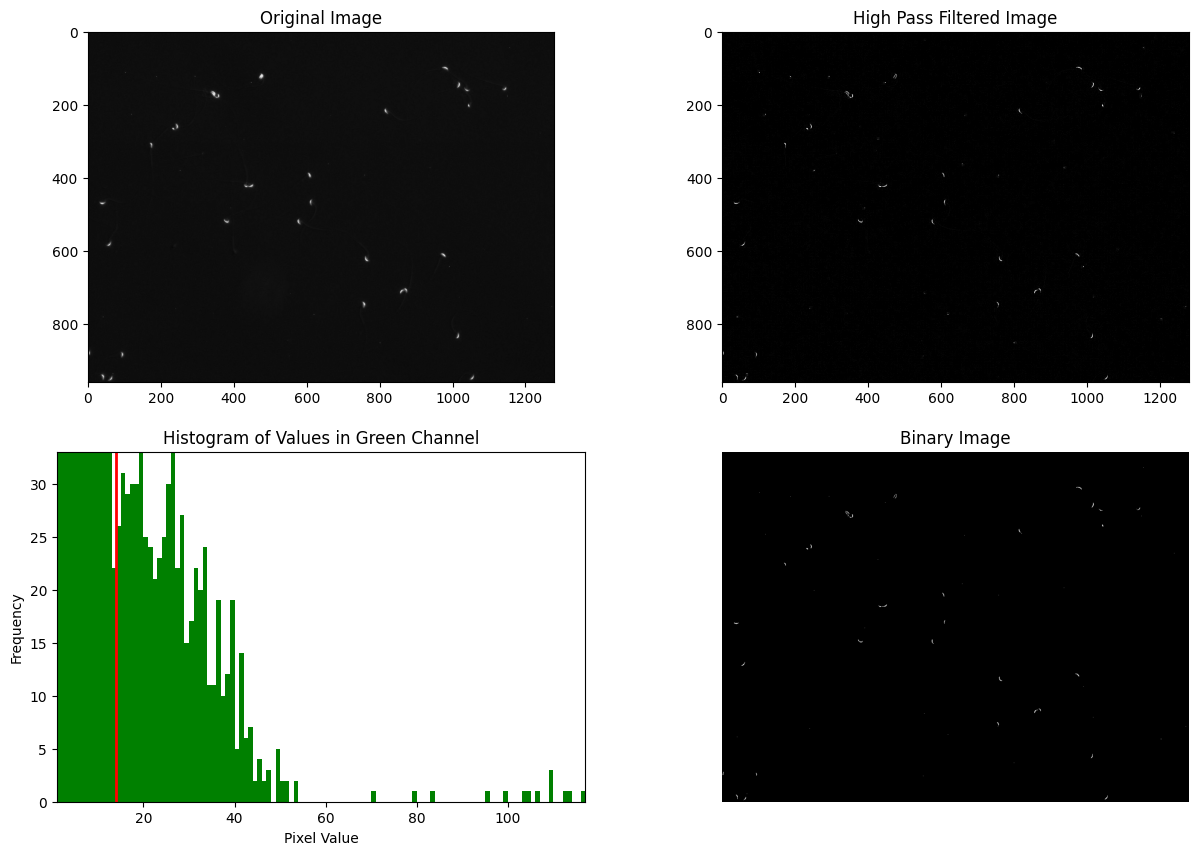

In [2]:
# High-pass filter image, find intensity threshold, and create binary image using Otsu’s binarization process

# user-defined size of gaussian kernel
kernel_size = 5

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply Gaussian blur to green channel
blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)
# Subtract the blurred image from the original grayscale image
high_pass_filtered_image = cv2.subtract(gray_image, blurred_image)
# Find intensity threshold and create binary image
ret, bin_img = cv2.threshold(high_pass_filtered_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('Thresholding image at', ret)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].imshow(gray_image, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].imshow(high_pass_filtered_image, cmap='gray', vmax=ret*2)
axs[0,1].set_title('High Pass Filtered Image')

# histogram of values 
counts, bin_edges = np.histogram(high_pass_filtered_image.flatten(), bins=256, range=[0,256])
axs[1,0].hist(high_pass_filtered_image.flatten(), bins=256, range=[0,256], color='green')
axs[1,0].set_title('Histogram of Values in Green Channel')
axs[1,0].set_xlabel('Pixel Value')
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_xlim(left=1, right=high_pass_filtered_image.flatten().max())
axs[1,0].set_ylim(top=counts[round(ret*.7)])

# Add a vertical red line at x=ret
axs[1,0].axvline(x=ret, color='red', linewidth=2)

# display binarized image
axs[1,1].imshow(bin_img, cmap='gray')
axs[1,1].axis('off')
axs[1,1].set_title('Binary Image')
plt.show()


Found 34 ROIs within expected size range


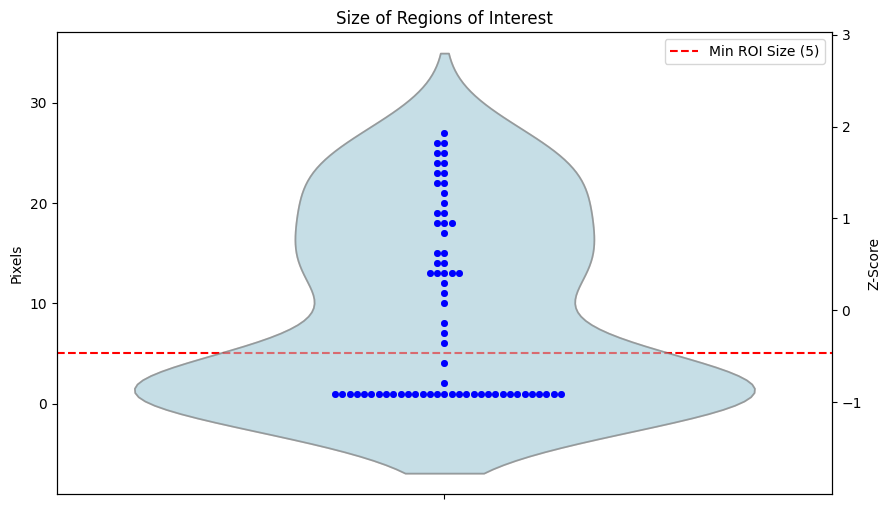

In [3]:
# Find Regions of Interest (ROIs) in the binary image

# user defined minimum/maximum ROI size in pixels
min_ROI_size = 5
# max ROI size
max_ROI_size = 500 

# Find ROIs of connected pixels, label each ROI with a unique integer
ret, markers = cv2.connectedComponents(bin_img)
# Count pixels in each ROI
pixel_counts, _ = np.histogram(markers.flatten(), bins=np.arange(markers.min(), markers.max() + 2))
# find number of ROIs larger than min_ROI_size excluding background
num_large_ROIs = np.sum((pixel_counts[1:] > min_ROI_size) & (pixel_counts[1:] < max_ROI_size))
print('Found', num_large_ROIs, 'ROIs within expected size range')

# Calculate z-scores of pixel_counts[1:]
z_scores = zscore(pixel_counts[1:])

# Create a figure with violin / swarm plots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot pixel_counts[1:] on the left axis
sns.swarmplot(y=pixel_counts[1:], ax=ax1, color='b')
ax1.set_ylabel('Pixels')
ax1.set_title('Size of Regions of Interest')
# Create a second y-axis to plot z_scores
ax2 = ax1.twinx()
sns.swarmplot(y=z_scores, ax=ax2, color='b')
ax2.set_ylabel('Z-Score')
# Overlay violin plot on the same figure
sns.violinplot(y=pixel_counts[1:], ax=ax1, inner=None, color='lightblue', alpha=0.5)
sns.violinplot(y=z_scores, ax=ax2, inner=None, color='lightblue', alpha=0.5)
# Add horizontal lines at min_ROI_size
ax1.axhline(y=min_ROI_size, color='red', linestyle='--', label=f'Min ROI Size ({min_ROI_size})')
ax1.legend()

plt.show()

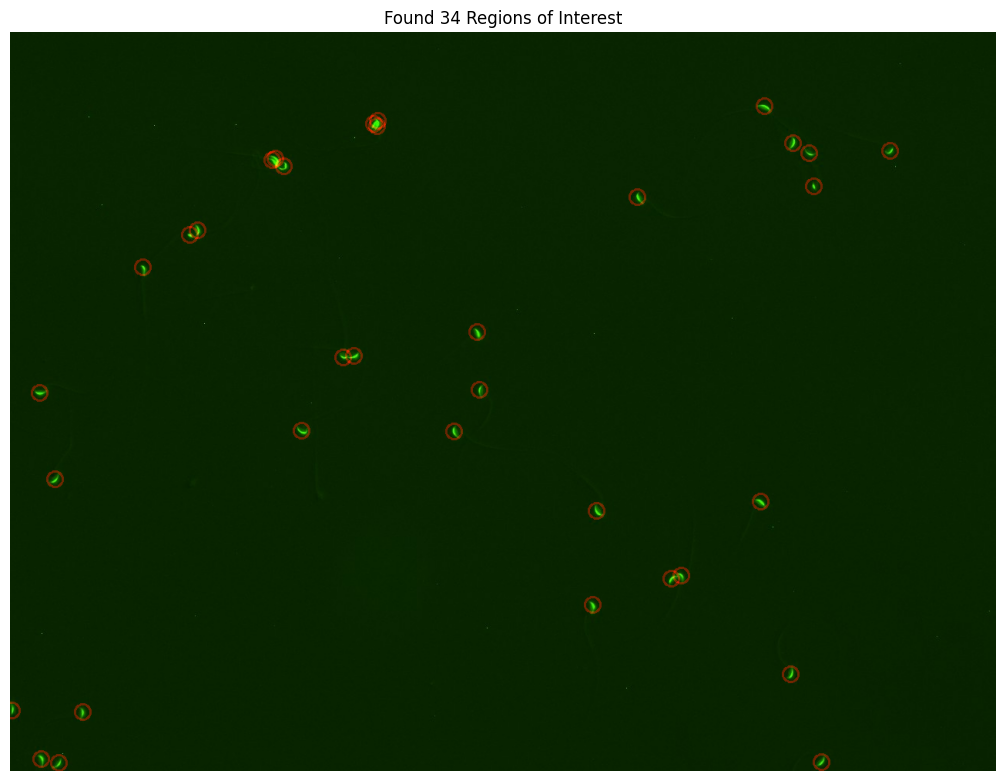

In [4]:
# Disply original image and draw circles around found Regions of Interest (ROIs)

# create a mask to exclude ROIs smaller than min_ROI_size
mask = (pixel_counts[markers] > min_ROI_size) & (pixel_counts[markers] < max_ROI_size)
# apply mask to markers
markers_final = mask * markers
unique_values = np.unique(markers_final)

# Create a copy of the original image to draw circles on
image_with_circles = image.copy()
# Iterate through the unique markers in markers_final
ctr = 0
for marker in unique_values:
    if marker == 0:
        continue  # Skip the background marker

    # Find the coordinates of the pixels with the current marker
    coords = np.column_stack(np.where(markers_final == marker))
    # Calculate the centroid of the marker
    centroid = np.mean(coords, axis=0).astype(int)
    # Create a temporary image to draw the circle
    temp_image = np.zeros_like(image_with_circles)
    cv2.circle(temp_image, (centroid[1], centroid[0]), radius=10, color=(255, 0, 0), thickness=2)
    # Blend the circle with the original image to achieve 50% opacity
    image_with_circles = cv2.addWeighted(image_with_circles, 1, temp_image, .4, 0)
    ctr += 1

# Display the image with circles
plt.figure(figsize=(width / 100, height / 100))
plt.imshow(image_with_circles)
plt.title(f'Found {ctr} Regions of Interest')
plt.axis('off')
plt.show()